# Clean Data

### Description:

Filter the three main data sources (Fund Info, Returns and Holdings)
based on some parameters and save the result.

Approach:
1. Match fund summary to each portfolio/date pair
2. Filter fund/date pairs based on those infos
3. Filter returns based on final sample of holdings
4. Save different versions of the files with different timeframes

Parameters: 
- Lipper_class
- Flags

## Setup
### All options for filtering the data

In [1]:
%matplotlib inline

import os
import sys

import feather
import pandasql as ps
import numpy as np
import pandas as pd
from scipy import sparse
import datetime

import matplotlib.pyplot as plt

In [2]:
options = {
    'sub_sample_start_date'      : datetime.date.fromisoformat('2015-01-01'),
    'sub_sample_end_date'        : datetime.date.fromisoformat('2018-01-01'),
    'min_per_com'                : 80,
    'min_tna_latest'             : 10,
    'min_obs_per_sec'            : 2,
    'min_obs_per_observation'    : 10,
    'min_perc_tna'               : 50,
    'max_perc_tna'               : 120,
    'selected_obj_codes'         : ('EIEI', 'G', 
                                    'LCCE', 'LCGE', 'LCVE',   # Large-cap
                                    'MCCE', 'MCGE', 'MCVE',   # Mid-cap
                                    'MLCE', 'MLGE', 'MLVE',   # Multi-cap
                                    'SCCE', 'SCGE', 'SCVE')   # Small-cap
}




### Load the data files

In [3]:
# Holdings data

npz_path = '../data/interim/holdings.npz'      # Preprocessed holdings data (see notebook 011)
holdings = sparse.load_npz(npz_path)

path = '../data/interim/row_info.feather'
row_info = feather.read_dataframe(path)
row_info_original = row_info.copy()

path = '../data/interim/col_info.feather'
col_info = feather.read_dataframe(path)

# Fund summary data

path = '../data/raw/fund_info.feather'
fund_info = feather.read_dataframe(path)     # Downloaded from wrds

path = '../data/raw/fund_summay.feather'
fund_summary = feather.read_dataframe(path)     # Downloaded from wrds

path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

path = '../data/raw/fund_style.feather'
fund_style = feather.read_dataframe(path)

# Returns data
path = '../data/raw/returns.feather'
returns = feather.read_dataframe(path)   # Downloaded from wrds

## Fix all data types

#### Fund info

In [4]:
fund_info.drop(columns= ['lipper_class','avrcs'],inplace=True)

fund_info.dropna(subset = ['crsp_portno','crsp_fundno'], inplace=True)
fund_info[['crsp_fundno','crsp_portno']] = pd.DataFrame(fund_info[['crsp_fundno','crsp_portno']],dtype=np.int64)

columns = ['first_offer_dt','begdt','enddt']
fund_info[columns] = fund_info[columns].apply(pd.to_datetime)

fund_info.loc[fund_info['et_flag'].isna(),'et_flag'] = 'MF'
fund_info.loc[fund_info['index_fund_flag'].isna(),'index_fund_flag'] = 'MF'

columns = ['et_flag','index_fund_flag']
fund_info[columns] = fund_info[columns].astype('category')

#fund_info[fund_info['style'] == 'EIEI'] = 'LCVE'
#fund_info[fund_info['style'] == 'G'] = 'LCGE'

et_mapper = {'F':'ETF', 'N':'ETN', 'MF':'MF'}
fund_info['et_flag'] = fund_info['et_flag'].cat.rename_categories(et_mapper)

index_flag_mapper = {'B':'Index-based', 'D':'Pure Index', 'E':'Index enhanced', 'MF':'MF'}
fund_info['index_fund_flag'] = fund_info['index_fund_flag'].map(index_flag_mapper)

#### Fund summary

In [5]:
fund_summary[['crsp_fundno']] = pd.DataFrame(fund_summary[['crsp_fundno']],dtype=np.int64)
columns = ['nav_latest','tna_latest','per_com']
fund_summary[columns] = pd.DataFrame(fund_summary[columns],dtype=np.float64)

columns = ['caldt','nav_latest_dt','tna_latest_dt']
fund_summary[columns] = fund_summary[columns].apply(pd.to_datetime)

#### Fund style

In [6]:
fund_style['crsp_fundno'] = fund_style['crsp_fundno'].astype('int64')

columns = ['begdt','enddt']
fund_style[columns] = fund_style[columns].apply(pd.to_datetime)

fund_style['cap_class'] = fund_style['lipper_class'].astype(str).str[0]
fund_style['style_class'] = fund_style['lipper_class'].astype(str).str[2]
fund_style.loc[
    ~fund_style['lipper_class'].isin(options.get('selected_obj_codes')),
    ['cap_class','style_class']] = np.NaN

columns = ['lipper_class','lipper_obj_cd','cap_class','style_class']
fund_style[columns] = fund_style[columns].astype('category')

#### Return

In [7]:
returns['crsp_fundno'] = pd.DataFrame(returns['crsp_fundno'],dtype=np.int64)
returns['caldt'] =  pd.to_datetime(returns['caldt'])

#### Portnomap

In [8]:
columns = ['crsp_fundno','crsp_portno']
portno_map[columns] = pd.DataFrame(portno_map[columns],dtype=np.int64)

columns = ['begdt','enddt']
portno_map[columns] = portno_map[columns].apply(pd.to_datetime)

### Filter based on fund summary

In [9]:
sqlcode = '''
    SELECT fund_summary.caldt, fund_summary.crsp_fundno, fund_summary.tna_latest, fund_summary.per_com,
    portno_map.begdt, portno_map.enddt, portno_map.crsp_portno, portno_map.crsp_fundno
    FROM fund_summary
    INNER JOIN portno_map 
    ON fund_summary.crsp_fundno = portno_map.crsp_fundno
    AND caldt BETWEEN portno_map.begdt AND portno_map.enddt;
'''

fund_summary_merged = ps.sqldf(sqlcode,locals())

columns = ['caldt','begdt','enddt']
fund_summary_merged[columns] = fund_summary_merged[columns].apply(pd.to_datetime)

fund_summary_merged = (fund_summary_merged
                           .groupby(['caldt','crsp_portno'])
                           .agg({'per_com': ['mean'],
                                 'tna_latest': ['sum']}))

fund_summary_merged.columns = fund_summary_merged.columns.droplevel(1)

fund_summary_merged = fund_summary_merged.query(
                            'per_com > {} and tna_latest > {}'.format(options.get('min_per_com'),
                                                                      options.get('min_tna_latest')))

### Filter based on fund info

In [10]:
fund_info = fund_info.query('''index_fund_flag == 'MF' and et_flag == 'MF' ''')

In [11]:
fund_info = fund_info.assign(portno_fundno = fund_info['crsp_fundno'] * 10_000_000 + fund_info['crsp_portno'])

selected_funds = fund_info[['crsp_portno','portno_fundno']].groupby(['crsp_portno']).first()

selected_funds = selected_funds['portno_fundno']

fund_info = fund_info.query('portno_fundno in @selected_funds')

fund_info = fund_info[['crsp_portno','crsp_fundno','fund_name','begdt','enddt']]

### Filter based on fund style

In [12]:
fund_style = fund_style[fund_style['lipper_class'].isin(options.get('selected_obj_codes'))]

## Merge

In [13]:
row_info.shape

(839196, 3)

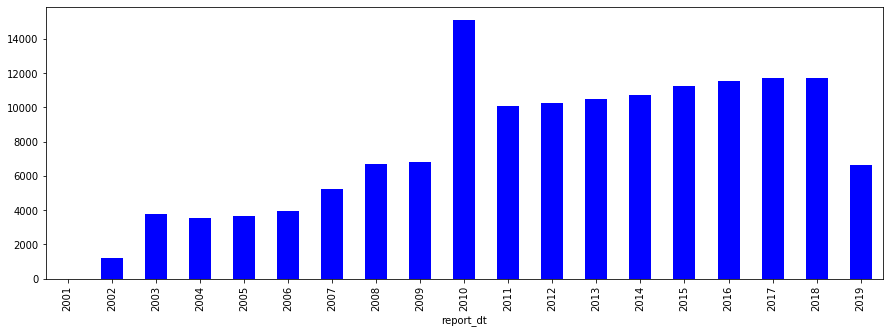

In [14]:
(row_info['crsp_portno']
    .groupby([
         row_info['report_dt'].dt.year,
     ])
     .nunique()
     .plot(kind='bar',
           color = 'b',
           figsize=(15,5)))

### Merge row_info and fund_info
Adds correct fundo to each portno/date row

In [15]:
row_info.shape

(839196, 3)

In [16]:
sqlcode = '''
    select row_info.crsp_portno, row_info.report_dt, 
    fund_info.crsp_portno, fund_info.crsp_fundno, fund_info.begdt, fund_info.enddt, fund_info.fund_name
    from row_info 
    inner join fund_info 
    on row_info.crsp_portno = fund_info.crsp_portno
    and row_info.report_dt between fund_info.begdt and fund_info.enddt;
'''

row_info_merged = ps.sqldf(sqlcode,locals())

columns = ['report_dt','begdt','enddt']
row_info_merged[columns] = row_info_merged[columns].apply(pd.to_datetime)
row_info_merged = row_info_merged[['crsp_portno','crsp_fundno','report_dt','begdt','enddt','fund_name']]
row_info_merged = row_info_merged.iloc[:,1:]

In [17]:
row_info_merged.shape

(529586, 6)

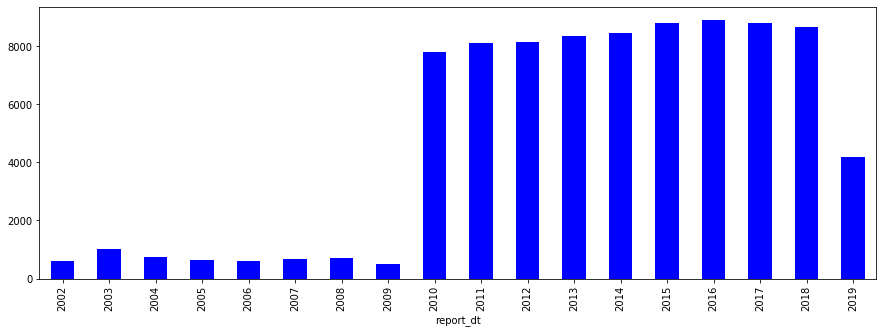

In [18]:
(row_info_merged['crsp_portno']
    .groupby([
         row_info_merged['report_dt'].dt.year,
#         row_info_merged['report_dt'].dt.month
     ])
     .nunique()
     .plot(kind='bar',
           color = 'b',
           figsize=(15,5)))

### Merge row_info and fund_style

In [19]:
fund_style = fund_style.rename(columns={'begdt':'style_begdt',
                                        'enddt':'style_enddt'})

In [20]:
sqlcode = '''
    SELECT 
        row_info_merged.crsp_fundno, row_info_merged.crsp_portno, row_info_merged.fund_name,
        row_info_merged.report_dt, row_info_merged.begdt, row_info_merged.enddt,
        fund_style.crsp_fundno, 
        fund_style.style_begdt, fund_style.style_enddt, 
        fund_style.lipper_class, fund_style.cap_class, fund_style.style_class
    FROM row_info_merged 
    INNER JOIN fund_style 
        ON row_info_merged.crsp_fundno = fund_style.crsp_fundno
        AND row_info_merged.report_dt between fund_style.style_begdt AND fund_style.style_enddt;
'''

row_info_merged = ps.sqldf(sqlcode,locals())

In [21]:
columns = ['report_dt','begdt','enddt','style_begdt','style_enddt']
row_info_merged[columns] = row_info_merged[columns].apply(pd.to_datetime)

In [22]:
row_info_merged = row_info_merged[['crsp_fundno','crsp_portno','fund_name',
                                   'report_dt','begdt','enddt','style_begdt','style_enddt',
                                  'lipper_class','cap_class','style_class']]
row_info_merged = row_info_merged.iloc[:,1:]

In [23]:
row_info_merged.shape

(172579, 11)

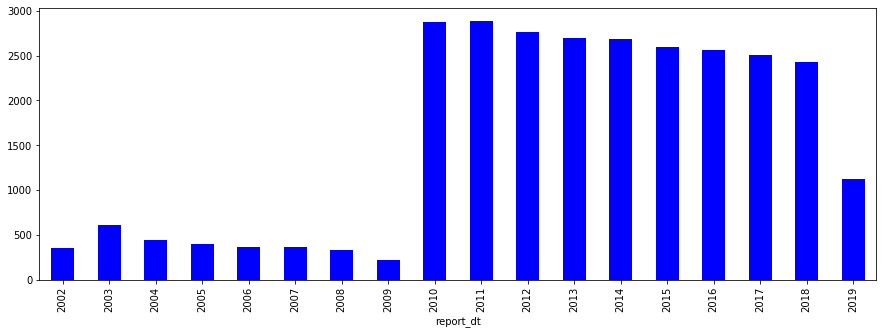

In [24]:
(row_info_merged['crsp_portno']
    .groupby([
         row_info_merged['report_dt'].dt.year,
#         row_info_merged['report_dt'].dt.month
     ])
     .nunique()
     .plot(kind='bar',
           color = 'b',
           figsize=(15,5)))

### Merge row_info and fund_hdr

In [25]:
row_info_merged = row_info_merged.merge(
    fund_summary[['crsp_fundno','caldt']],
    how='inner',
    left_on=['crsp_fundno','report_dt'],
    right_on=['crsp_fundno','caldt'])

In [26]:
row_info_merged.shape

(54762, 12)

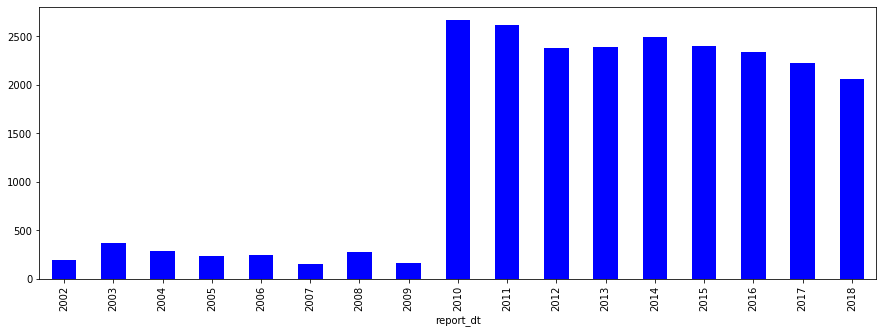

In [27]:
(row_info_merged['crsp_portno']
    .groupby([
         row_info_merged['report_dt'].dt.year,
#         row_info_merged['report_dt'].dt.month
     ])
     .nunique()
     .plot(kind='bar',
           color = 'b',
           figsize=(15,5)))

### Drop all unused columns of row_info

In [28]:
row_info = row_info_merged.drop(columns=['caldt','begdt','enddt','style_begdt','style_enddt'])

### Merge row_info with holdings

In [29]:
row_info_original = row_info_original.assign(row_old = row_info_original.index)
col_info = col_info.assign(col_old = col_info.index)

row_info = row_info.merge(row_info_original,how='left',on=['crsp_portno','report_dt'])

In [30]:
# Filter holdings matrix based on merged and filtered row_info
mask = row_info['row_old'].values
holdings = holdings[mask]

In [31]:
# Drop unused columns and reset index / row column
row_info.drop(columns=['port_id','row_old'],inplace=True)
row_info.reset_index(drop=True,inplace=True)
row_info = row_info.assign(row = row_info.index)

### Filter based on holdings

#### Delete securities with little to no information

In [32]:
# Generate sparse holdings matrix with boolean values instead of more precise percent_tna values
holdings_b = sparse.csr_matrix(holdings, copy=True)
holdings_b.data = np.ones(len(holdings.data))

In [33]:
sum_sec_boolean = pd.DataFrame(holdings_b.sum(0).T).values
sum_port_boolean = pd.DataFrame(holdings_b.sum(1)).values

sum_sec_perc = pd.DataFrame(holdings.sum(0).T).values
sum_port_perc = pd.DataFrame(holdings.sum(1)).values

In [34]:
print('Total number of securities:               {:>10,d}'.format(len(sum_sec_boolean)))
print('Total number of securities with >1:       {:>10,d}'.format(np.sum(sum_sec_boolean > 1)))
print('Total number of securities with >10:      {:>10,d}'.format(np.sum(sum_sec_boolean > 10)))
print('Total number of securities with >50:      {:>10,d}'.format(np.sum(sum_sec_boolean > 50)))
print('Total number of securities with >100:     {:>10,d}'.format(np.sum(sum_sec_boolean > 100)))

Total number of securities:                1,621,421
Total number of securities with >1:           56,820
Total number of securities with >10:          21,819
Total number of securities with >50:           9,203
Total number of securities with >100:           6,597


In [35]:
# Each security has to appear at least x times stocks
col_mask = (sum_sec_boolean >= options.get('min_obs_per_sec')).flatten()
# Each portfolio has to have at least x stocks
row_mask_1 = (sum_port_boolean >= options.get('min_obs_per_observation')).flatten()
# Each portfolio has to have min x% sum of percent_tna
row_mask_2 = (sum_port_perc >= options.get('min_perc_tna')).flatten()
# Each portfolio has to have max x% sum of percent_tna
row_mask_3 = (sum_port_perc <= options.get('max_perc_tna')).flatten()
row_mask = row_mask_1 & row_mask_2 & row_mask_3

In [36]:
# Overview of masks
print('Cols matching criteria according to:''\n',
    'No mask  : {:10,d}'.format(len(col_mask)),'\n',
    'Full mask: {:10,d}'.format(np.sum(col_mask)),'\n')

print('Rows matching criteria according to:''\n',
    'No mask  : {:10,d}'.format(len(row_mask_1)),'\n',
    'Mask    1: {:10,d}'.format(np.sum(row_mask_1)),'\n',
    'Mask    2: {:10,d}'.format(np.sum(row_mask_2)),'\n',
    'Mask    3: {:10,d}'.format(np.sum(row_mask_3)),'\n',
    'Full mask: {:10,d}'.format(np.sum(row_mask)))

Cols matching criteria according to:
 No mask  :  1,621,421 
 Full mask:     56,820 

Rows matching criteria according to:
 No mask  :     54,762 
 Mask    1:     53,865 
 Mask    2:     54,515 
 Mask    3:     54,617 
 Full mask:     53,554


In [37]:
# Apply masks
holdings = holdings.tocsc()
holdings = holdings[:,col_mask]
holdings = holdings.tocsr()
holdings = holdings[row_mask,:]

holdings_b = holdings_b.tocsc()
holdings_b = holdings_b[:,col_mask]
holdings_b = holdings_b.tocsr()
holdings_b = holdings_b[row_mask,:]

col_info = col_info.loc[col_mask,:]
row_info = row_info.loc[row_mask,:]

# reset indices
col_info.reset_index(drop=True,inplace=True)
col_info = col_info.assign(col = col_info.index)

row_info.reset_index(drop=True,inplace=True)
row_info = row_info.assign(row = row_info.index)

In [38]:
# Check if all dimensions match
print('Number of fund/date combinations:        {:12,d}'.format(holdings.shape[0]))
print('Number of unique securities:             {:12,d}'.format(holdings.shape[1]))
print('Number of values in sparse matrix:       {:12,d}'.format(holdings.getnnz()))
match_test = ((holdings.shape[0] == holdings_b.shape[0]) 
              & (holdings.shape[1] == holdings_b.shape[1]) 
              & (holdings.getnnz() == holdings_b.getnnz()))
print('Same values for boolean holdings matrix:         {}'.format(match_test))
print()
print('Number of rows in row_info df:           {:12,d}'.format(row_info.shape[0]))
print('Number of rows in col_inf df:            {:12,d}'.format(col_info.shape[0]))
print()
match_test = (holdings.shape[0] == row_info.shape[0]) & (holdings.shape[1] == col_info.shape[0])
print('Everything matches:                              {}'.format(match_test))

Number of fund/date combinations:              53,554
Number of unique securities:                   56,820
Number of values in sparse matrix:          6,914,239
Same values for boolean holdings matrix:         True

Number of rows in row_info df:                 53,554
Number of rows in col_inf df:                  56,820

Everything matches:                              True


## Filter holdings accordingly

In [39]:
fund_nos = row_info['crsp_fundno'].unique()

returns = returns.query('crsp_fundno in @fund_nos')

## Check if holdings data still makes sene

In [40]:
def most_common_stocks(date,lipper_class):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    date = pd.to_datetime(date)
    lipper_class = lipper_class

    # Change if you want tu sum percentages instead of boolean values
    holdings_coo = holdings_b.tocoo()

    df_sparse = pd.DataFrame({'row' : holdings_coo.row,
                              'col' : holdings_coo.col,
                              'data' : holdings_coo.data})

    df_sparse = df_sparse.merge(row_info[['report_dt','row','lipper_class']],how='left',on='row')

    my_filter = '''report_dt == @date and lipper_class == @lipper_class '''

    no_unique_funds = row_info.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .sum()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data / no_unique_funds * 100)
               .drop(columns=['row','data','col'])
               .reset_index(drop=True)
               .head(10))

    print(
        'Most held stocks: ','\n\n'
        'Lipper class:       {}'.format(lipper_class),'\n'
        'Number of funds:    {}'.format(no_unique_funds),'\n'
        'Date:               {}'.format(date.date()))

    return sum_col

In [41]:
most_common_stocks(date='2016-06-30',lipper_class='LCCE')

Most held stocks:  

Lipper class:       LCCE 
Number of funds:    265 
Date:               2016-06-30


,security_name,percent
0,APPLE INC,79.245283
1,MICROSOFT CORP,77.358491
2,WELLS FARGO & CO NEW,66.792453
3,COMCAST CORP NEW,65.660377
4,JOHNSON & JOHNSON,64.150943
5,JPMORGAN CHASE & CO,63.773585
6,ALPHABET INC,61.886792
7,ALPHABET INC,60.000000
8,CISCO SYSTEMS INC,58.490566
9,SCHLUMBERGER NV ORD,56.603774


# Save everything

In [42]:
# Holdings data
path = '../data/processed/holdings.npz'
sparse.save_npz(path,holdings)

path = '../data/processed/row_info.feather'
feather.write_dataframe(row_info,path)

path = '../data/processed/col_info.feather'
feather.write_dataframe(col_info,path)

# Returns data
path = '../data/processed/returns.feather'
feather.write_dataframe(returns,path)   # Downloaded from wrds

## Tests

In [43]:
fund_style.query('crsp_fundno == 38200')

,crsp_fundno,style_begdt,style_enddt,lipper_class,lipper_obj_cd,cap_class,style_class
118894,38200,2008-10-24,2018-01-18,SCCE,CA,S,C
118895,38200,2018-01-19,2019-06-30,MLCE,G,M,C


In [44]:
def most_common_stocks_fund(year,crsp_fundno):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    df_sparse = df_sparse.merge(row_info[['year','row','crsp_fundno']],how='left',on='row')
    row_info_s = row_info.assign(year = row_info['report_dt'].dt.year)
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_s.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Year:                                   {}'.format(year),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col

In [45]:
most_common_stocks_fund(year=2017, crsp_fundno='28284')

KeyError: "['year'] not in index"